In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import jax
import scipy
from scipy.stats import invwishart
from scipy.stats import beta
from scipy.special import digamma
from numpy.random import multivariate_normal as mvn
import matplotlib.pyplot as plt
from matplotlib import cm

##**GENERAZIONE DATI**

This is the model for cluster paramters (so a sort of $G_0$):
\begin{align*}
  \Sigma_k &\stackrel{\tiny\mbox{iid}}{\sim} \mathcal{W}^{-1}\left(d,\ \Sigma_0\right) & k=1,...,K \\
  \mu_k & \stackrel{\tiny\mbox{iid}}{\sim} \mathcal{N}_d\left(\mu_0,\ \Sigma_k\right) & k=1,...,K \\
\end{align*}
with K the number of clusters, not known a priori, defined during data generation

Data model:
\begin{align*}
  X_i|\eta,z_i \stackrel{\tiny\mbox{}}{\sim} \mathcal{N}_d\left(\mu_{z_i},\ \Sigma_{z_i}\right) \quad \quad i=1,...,N
\end{align*}
with $\eta$ such that $\eta_k$ is equal to the mean and varianc for each cluster $k=1,....,K$

DA METTERE A POSTO, NEL PAPER C'E' LA DISTRIBUZIONE DI $x_n$ CONDIZIONATA \\
SEGUE FAMIGLIA ESPONENZIALE

0.9999999999999999


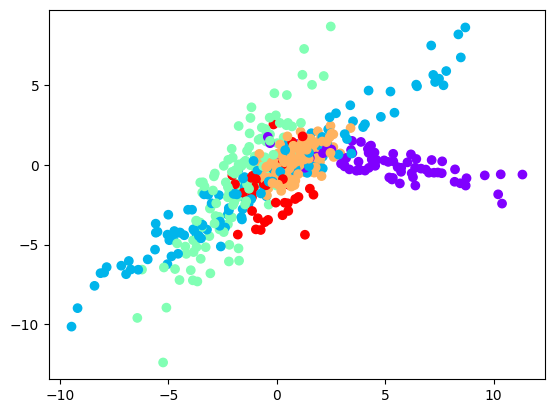

In [ ]:
np.random.seed(2023)

# Instantiate the first topic
alpha = 5
n = 1000
d = 2

assignment = [0] # first point must be assigned to first cluster
rho_1 = beta(1, alpha).rvs()
remainder = 1-rho_1
rhos = [remainder, rho_1]
new_or_existk = [-1, 0]
ntopics =1
mu0 = np.zeros(d)
sigma0 = np.identity(d)

cov1 = invwishart(df=2, scale=sigma0).rvs()
mu1 = mvn(mu0, cov1)

mus = [mu1]
covs = [cov1]

for i in range(1, n):
  k = np.random.choice(new_or_existk, p=rhos)
  if k==-1:
    # generate new topic
    new_rho = beta(1, alpha).rvs() * remainder
    remainder -= new_rho
    rhos[0] = remainder
    rhos.append(new_rho)

    ntopics += 1
    assignment.append(ntopics-1) #zero-based indexing
    new_or_existk.append(ntopics-1)
    # generation of new cluster parameters
    # choose a distribution G_0 for the cluster parameters, then a distribution for data given the cluster parameters
    new_cov = invwishart(df=d, scale=sigma0).rvs()
    new_mu = mvn(mean=mu0, cov=new_cov)
    mus.append(new_mu)
    covs.append(new_cov)
  else:
    assignment.append(k)

rhos=rhos/np.aum(rhos)

print(np.sum(rhos))

# data generation
datapoints = []
colors = cm.rainbow(np.linspace(0, 1, ntopics))
cs = []

for i in assignment:
  x = mvn(mean=mus[i], cov=covs[i])
  datapoints.append(x)
  cs.append(colors[i])

xs = [d[0] for d in datapoints]
ys = [d[1] for d in datapoints]

plt.scatter(xs, ys, color=cs)
plt.show()

## CAVI FOR DP MIXTURE

In [ ]:
def update_phi(data,gamma,tau1,tau2,a):
  # a è la funzione proposta da noi della distribuzione esponenziale di eta*
  grad_a=jit(jax.grad(a))
  sum_terms2=jnp.zeros(T)

  def cond(state):
    t,_,_,_,_=state
    return (t>0)

  def true_fun(state):
    t,x,gamma,n_integral,sum_terms2=state
    term2=digamma(gamma[t-1,1])-digamma(gamma[t-1,0]+gamma[t-1,1])
    sum_terms2.at[t].set(sum_terms2[t-1]+term2)
    return sum_terms2

  def false_fun(state):
    _,_,_,_,sum_terms2=state
    return sum_terms2

  updated_phi=jnp.zeros((N,T))
  for t in jnp.arange(T):
    term1=digamma(gamma[t,0])-digamma(gamma[t,0]+gamma[t,1])
    state=(t,x,gamma,n_integral,sum_terms2)
    sum_terms2=jax.lax.cond(cond,true_fun,false_fun,state)
    for n in jnp.arange(N):
      updated_phi.at[n,t].add(term1 + sum_terms2 + grad_a(tau1) @ data[n,:].T - a(grad_a(tau1)))
  updated_phi/=jnp.sum(updated_phi,axis=1,keepdims=True)

  ''' IF WE NEED TO COMPUTE log(phi) THEN UNCOMMENT THIS SECTION
  def true_fun(updated_phi):
    updated_phi +=10**-10
    updated_phi /= jnp.sum(updated_phi,axis=1,keepdims=True)
    return updated_phi

  def false_fun(updated_phi):
    return updated_phi

  updated_phi=jax.lax.cond((jnp.sum(updated_phi==0)>0), true_fun, false_fun,updated_phi)
  '''
  return updated_phi


def update_gamma(alpha,phi,T):
  gamma=jnp.empty((T-1,2))
  gamma[:,0]=1+jnp.sum(phi[:,:-1],axis=0) # ultima riga di phi non ci deve essere
  for t in range(T-1):
    gamma.at[t,1].set(alpha+jnp.sum(jnp.sum(phi[:,t+1:],axis=1),axis=0))
  return


def update_tau(data,phi,lam):
  tau1=lam[0]+jnp.matmul(phi.T,data)
  tau2=lam[1]+jnp.sum(phi,axis=0)
  return tau1,tau2


def compute_ELBO(data,gamma,tau1,tau2,phi,alpha,a):  # abbiamo bisogno di h o scegliamo la distribuzione tale che è inutile?
  N=data.shape[0]
  T=phi.shape[1]
  T1=0
  for t in range(T):
    y=fun1(x)
    T1+=(alpha-1)*(digamma(gamma[t,1])-digamma(gamma[t,0]+gamma[t,1]))
    # -log(beta(1,alpha)) in teoria non c'è perchè diventa log(beta(1,alpha))*densità inegrata quindi rimane solo somma di log(beta(1,alpha)), costante ogni iterazione

  T2=0
  # ?????????????

  T3=0
  for n in jnp.arange(N):
    for t in jnp.arange(T-1):  # fatto fino a T-1 per evitare out of bounds del primo termine nell'ultima iterazione
      T3+= jnp.sum(phi[n,t+1:])*(digamma(gamma[t,1])-digamma(gamma[t,0]+gamma[t,1]))+phi[n,t]*(digamma(gamma[t,0])-digamma(gamma[t,0]+gamma[t,1]))
    T3+=+phi[n,T-1]*(digamma(gamma[T-1,0])-digamma(gamma[T-1,0]+gamma[T-1,1]))
    # primo termine si annulla in T perchè abbiamo troncato la somma a T, quindi tutti gli elementi più grandi sono 0

  T4=0
  # ???????????????

  T5=0
  for t in jnp.arange(T-1):
    T5+= # ???????????
    T5+= -jnp.log(beta(gamma[t,0],gamma[t,1]))+(gamma[t,0]-1)*(digamma(gamma[t,0])-digamma(gamma[t,0]+gamma[t,1]))+(gamma[t,1]-1)*(digamma(gamma[t,1])-digamma(gamma[t,0]+gamma[t,1]))
  T5+= # ??????????? secondo elemento con t=T
  T5+= jnp.sum(jnp.log(phi)*phi)

  return T1+T2+T3+T4-T5

In [ ]:
def single_iteration_VI(data,T,i,nMax,tol):
  # initialize the parameters
  N=data.shape[0]
  d=data.shape[1]
  key = random.PRNGKey(i*seed)
  phi=random.uniform(key,minval=0,maxval=1,shape=(N,T))
  phi/=jnp.sum(phi,axis=1,keepdims=True)
  tau1=random.normal(key,shape=(T,d))
  tau2=random.normal(key,shape=(T,1))
  gamma=random.geometric(key,0.25,(T-1,2))
  improvement=1
  ELBO_new=compute_ELBO_jit(m,s2,phi,data)
  ELBO_old=ELBO_new-1
  nit=0

  def cond(state):
    _,_,_,_,_,nit,ELBO,improvement,tol,nMax=state
    return (((improvement>tol) & (nit<nMAX)) | (ELBO==jnp.nan))

  def iteration_while(state):
    data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMAX=state
    phi=update_phi(data,gamma,tau1,tau2,a)
    gamma=update_gamma(alpha,phi,T)
    tau1,tau2=update_tau(data,phi,lam)
    ELBO_old=ELBO_new
    ELBO_new=compute_ELBO()
    improvement=ELBO_new-ELBO_old
    nit+=1
    return (data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMAX)

  state=(data,gamma,tau1,tau2,phi,nit,ELBO_new,improvement,tol,nMAX)
  _,gamma,tau1,tau2,phi,nit,ELBO_new,_,_,_=jax.lax.while_loop(cond_fun=cond,body_fun=iteration_while,init_val=state)
  tau=[tau1,tau2]

  return  gamma,tau,phi,ELBO_new,nit

In [ ]:
def VI(data,T,nMax,n_iniz,tol):
  ELBO_max=0
  for i in range(n_iniz):
    gamma,tau,phi,nit=single_iteration_VI_jit(data,T,i,nMax,tol) # we may need to add some hyperparameters like sigma in gaussian case
    if i==0:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=0
    print('Initialization number: ',i+1,'\t ELBO: ',ELBO_new,'\t N_iterations: ',nit)
    print('=================================================\n')
    if ELBO_new>ELBO_max:
      ELBO_max=ELBO_new
      gamma_max=gamma
      tau_max=tau
      phi_max=phi
      n_max=i
  print('Best initialization at ',n_max+1,' \t ELBO: ',ELBO_max,'\n\n')
  return gamma_max,tau_max,phi_max